In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

pd.set_option('display.max_columns',None)
pd.set_option('display.max_row',None)

In [94]:
raw_Data = pd.read_csv('/Users/pritigirishvankudre/DayX_Lockdown Practice/CC_Lead_Pred/train.csv')
raw_Data.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,NNVBBKZB,Female,73,RG268,Other,X3,43,No,1045696,No,0
1,IDD62UNG,Female,30,RG277,Salaried,X1,32,No,581988,No,0
2,HD3DSEMC,Female,56,RG268,Self_Employed,X3,26,No,1484315,Yes,0
3,BF3NC7KV,Male,34,RG270,Salaried,X1,19,No,470454,No,0
4,TEASRWXV,Female,30,RG282,Salaried,X1,33,No,886787,No,0


In [95]:
# Data information

raw_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245725 entries, 0 to 245724
Data columns (total 11 columns):
ID                     245725 non-null object
Gender                 245725 non-null object
Age                    245725 non-null int64
Region_Code            245725 non-null object
Occupation             245725 non-null object
Channel_Code           245725 non-null object
Vintage                245725 non-null int64
Credit_Product         216400 non-null object
Avg_Account_Balance    245725 non-null int64
Is_Active              245725 non-null object
Is_Lead                245725 non-null int64
dtypes: int64(4), object(7)
memory usage: 20.6+ MB


In [96]:
# Describing the data

raw_Data.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,245725.000000,245725.000000,2.457250e+05,245725.000000
mean,43.856307,46.959141,1.128403e+06,0.237208
std,14.828672,32.353136,8.529364e+05,0.425372
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.043100e+05,0.000000
50%,43.000000,32.000000,8.946010e+05,0.000000
75%,54.000000,73.000000,1.366666e+06,0.000000
max,85.000000,135.000000,1.035201e+07,1.000000


In [97]:
'''
Mehtod to understand Null values distribution
'''
col_null = pd.DataFrame(raw_Data.isnull().sum()).reset_index()
col_null.columns = ['DataColumns','NullCount']
col_null['NullCount_Pct'] = round((col_null['NullCount']/raw_Data.shape[0])*100,2)
display (col_null)

,DataColumns,NullCount,NullCount_Pct
0,ID,0,0.00
1,Gender,0,0.00
2,Age,0,0.00
3,Region_Code,0,0.00
4,Occupation,0,0.00
5,Channel_Code,0,0.00
6,Vintage,0,0.00
7,Credit_Product,29325,11.93
8,Avg_Account_Balance,0,0.00
9,Is_Active,0,0.00


In [98]:
'''
Method to understand Unique values distribution
'''

col_uniq = pd.DataFrame(raw_Data.nunique()).reset_index()
col_uniq.columns = ['DataColumns','UniqCount']
col_uniq_cnt = pd.DataFrame(raw_Data.count(axis=0)).reset_index()
col_uniq_cnt.columns = ['DataColumns','UniqCount']
col_uniq['UniqCount_Pct'] = round((col_uniq['UniqCount']/col_uniq_cnt['UniqCount'])*100,2)
display (col_uniq)

,DataColumns,UniqCount,UniqCount_Pct
0,ID,245725,100.00
1,Gender,2,0.00
2,Age,63,0.03
3,Region_Code,35,0.01
4,Occupation,4,0.00
5,Channel_Code,4,0.00
6,Vintage,66,0.03
7,Credit_Product,2,0.00
8,Avg_Account_Balance,135292,55.06
9,Is_Active,2,0.00


# To treat Null values of Credit_Product

In [99]:
raw_Data['Credit_Product'].value_counts()

No     144357
Yes     72043
Name: Credit_Product, dtype: int64

In [100]:
# To balance the data, lets fill NA values for Credit_Product as 'Yes'

raw_Data_treat = raw_Data.copy()
raw_Data_treat['Credit_Product'].fillna('Yes', inplace=True)

# Exploratroy Data Analysis - Understanding the Target Variable Trend with resepct to Features

In [28]:
# Relation between Gender and Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Gender','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index()
display (b)

,Gender,Is_Lead,count,percent
0,Female,0,88823,47.39
1,Female,1,22705,38.95
2,Male,0,98614,52.61
3,Male,1,35583,61.05


There seems great opportunity to tap the potetial Male as well Female count which could be brought under Credit Card Business

In [29]:
# Relation between Occupation and Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Occupation','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index().sort_values(by='Occupation',ascending=False)
display (b)

,Occupation,Is_Lead,count,percent
6,Self_Employed,0,73045,38.97
7,Self_Employed,1,27841,47.76
4,Salaried,0,60503,32.28
5,Salaried,1,11496,19.72
2,Other,0,52984,28.27
3,Other,1,17189,29.49
0,Entrepreneur,0,905,0.48
1,Entrepreneur,1,1762,3.02


In [30]:
# Relation between Gender, Occupation with distribution against Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Gender','Occupation','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index().sort_values(by='Occupation',ascending=False)
display (b)

,Gender,Occupation,Is_Lead,count,percent
6,Female,Self_Employed,0,29991,29.73
7,Female,Self_Employed,1,10631,10.54
14,Male,Self_Employed,0,43054,42.68
15,Male,Self_Employed,1,17210,17.06
4,Female,Salaried,0,34413,47.80
5,Female,Salaried,1,5083,7.06
12,Male,Salaried,0,26090,36.24
13,Male,Salaried,1,6413,8.91
2,Female,Other,0,24083,34.32
3,Female,Other,1,6340,9.03


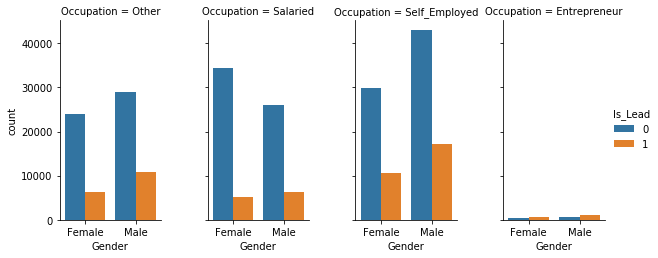

In [31]:
sns.catplot(x="Gender", col="Occupation", hue="Is_Lead", col_wrap=4, data=raw_Data_treat, kind="count", height=3.5, aspect=.6)
plt.show()

Either Entreprenuer category is least reported in the data collected or the Happy Customer Bank is not tapping potential of the category. For rest other category, even though count reported is good in terms of customer base, its ratio of turning into Credit Card business does not seem to be great.

In [32]:
# Relation between Region_Code and Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Region_Code','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index().sort_values(by=['Is_Lead','count'],ascending=False)
display (b[b['Is_Lead']==1].head())
display (b[b['Is_Lead']==1].tail())
display (b[b['Is_Lead']==0].head())
display (b[b['Is_Lead']==0].tail())

,Region_Code,Is_Lead,count,percent
37,RG268,1,10773,18.48
67,RG283,1,8885,15.24
69,RG284,1,5816,9.98
9,RG254,1,5713,9.80
61,RG280,1,3009,5.16


,Region_Code,Is_Lead,count,percent
29,RG264,1,383,0.66
25,RG262,1,323,0.55
43,RG271,1,261,0.45
35,RG267,1,223,0.38
33,RG266,1,220,0.38


,Region_Code,Is_Lead,count,percent
36,RG268,0,25161,13.42
8,RG254,0,21127,11.27
66,RG283,0,20531,10.95
68,RG284,0,13504,7.20
54,RG277,0,9851,5.26


,Region_Code,Is_Lead,count,percent
6,RG253,0,1377,0.73
32,RG266,0,1358,0.72
42,RG271,0,1281,0.68
34,RG267,0,1274,0.68
30,RG265,0,1146,0.61


In [33]:
# Relation between Gender, Region_Code with distribution against Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Gender','Region_Code','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index().sort_values(by=['Is_Lead','count'],ascending=False)
display (b[b['Is_Lead']==1].head())
display (b[b['Is_Lead']==1].tail())
display (b[b['Is_Lead']==0].head())
display (b[b['Is_Lead']==0].tail())

,Gender,Region_Code,Is_Lead,count,percent
107,Male,RG268,1,6269,17.45
137,Male,RG283,1,5132,17.45
37,Female,RG268,1,4504,12.53
67,Female,RG283,1,3753,12.76
79,Male,RG254,1,3726,13.88


,Gender,Region_Code,Is_Lead,count,percent
105,Male,RG267,1,126,8.42
43,Female,RG271,1,114,7.39
25,Female,RG262,1,113,6.32
35,Female,RG267,1,97,6.48
33,Female,RG266,1,80,5.07


,Gender,Region_Code,Is_Lead,count,percent
106,Male,RG268,0,13781,38.35
78,Male,RG254,0,11658,43.44
36,Female,RG268,0,11380,31.67
136,Male,RG283,0,11232,38.18
8,Female,RG254,0,9469,35.28


,Gender,Region_Code,Is_Lead,count,percent
112,Male,RG271,0,619,40.14
56,Female,RG278,0,605,33.21
104,Male,RG267,0,590,39.41
6,Female,RG253,0,556,29.92
30,Female,RG265,0,522,33.76


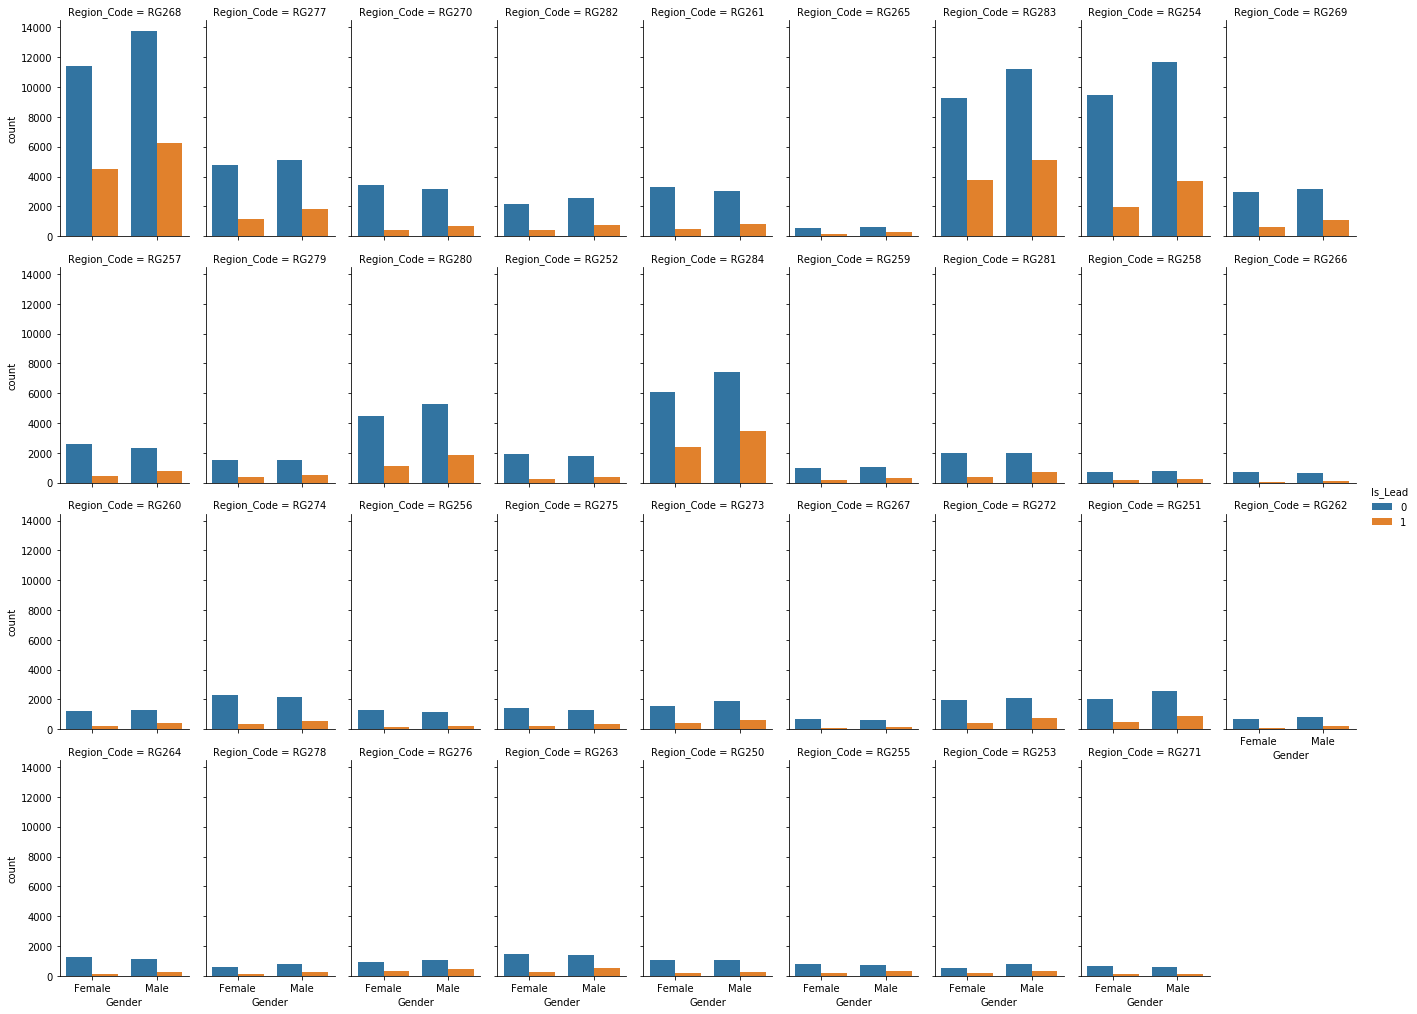

In [34]:
sns.catplot(x="Gender", col="Region_Code", hue="Is_Lead", col_wrap=9, data=raw_Data_treat, kind="count", height=3.5, aspect=.6)
plt.show()

Region wise Happy Customer Bank need to target Region with low 'Is_Lead = 1' count. At the same time target also need to set to convert Region with high 'Is_Lead = 0'.

Compared to Region_Code like RG268, RG283, RG254 rest all regions show poor customer base. A review of marketing campaign needs to be undertaken to tap the potential.

In [35]:
# Relation between Channel_Code and Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Channel_Code','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index().sort_values(by=['Channel_Code'],ascending=False)
display (b)

,Channel_Code,Is_Lead,count,percent
6,X4,0,4189,2.23
7,X4,1,1380,2.37
4,X3,0,43493,23.20
5,X3,1,25219,43.27
2,X2,0,45519,24.28
3,X2,1,22207,38.10
0,X1,0,94236,50.28
1,X1,1,9482,16.27


In [36]:
# Relation between Gender, Channel_Code with distribution against Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Gender','Channel_Code','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
#b = a.copy().reset_index().sort_values(by=['Channel_Code'],ascending=False)
display (a)

count  percent
Gender Channel_Code Is_Lead                
Female X1           0        53308    51.40
                    1         4907     4.73
       X2           0        16624    24.55
                    1         7773    11.48
       X3           0        17278    25.15
                    1         9473    13.79
       X4           0         1613    28.96
                    1          552     9.91
Male   X1           0        40928    39.46
                    1         4575     4.41
       X2           0        28895    42.66
                    1        14434    21.31
       X3           0        26215    38.15
                    1        15746    22.92
       X4           0         2576    46.26
                    1          828    14.87

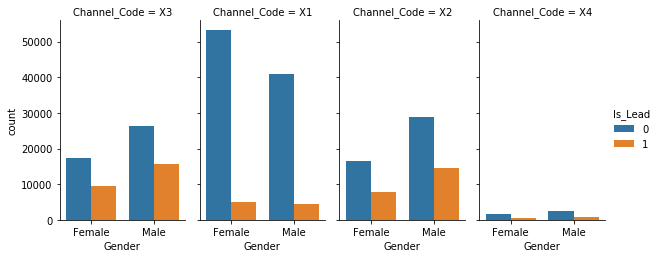

In [37]:
sns.catplot(x="Gender", col="Channel_Code", hue="Is_Lead", col_wrap=4, data=raw_Data_treat, kind="count", height=3.5, aspect=.6)
plt.show()

The channel code X4 needs to be reviewed for better reach to customer base. Channel Code X1 even though high in numbers still conversion rate seems low both with Male and Female genders. Channel code X3 seems doing fairly in terms of making people interested in Credit Card business.

In [38]:
# Relation between Gender, Credit_Product with distribution against Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Gender','Credit_Product','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index()
display (b)

,Gender,Credit_Product,Is_Lead,count,percent
0,Female,No,0,65505,45.38
1,Female,No,1,4671,3.24
2,Female,Yes,0,23318,23.00
3,Female,Yes,1,18034,17.79
4,Male,No,0,68229,47.26
5,Male,No,1,5952,4.12
6,Male,Yes,0,30385,29.97
7,Male,Yes,1,29631,29.23


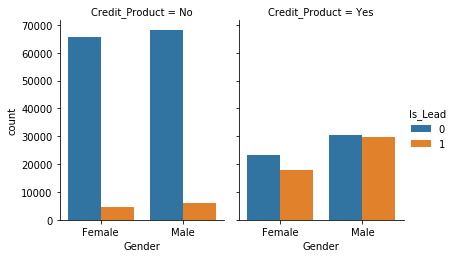

In [39]:
sns.catplot(x="Gender", col="Credit_Product", hue="Is_Lead", col_wrap=2, data=raw_Data_treat, kind="count", height=3.5, aspect=.8)
plt.show()

Other than Credit Card, there is ample opportunity available where customers can be targeted for different credit products. Looking at Credit_Product entitlement there seems fairly equal chance that a customer is also interested in Credit Card.

In [40]:
# Relation between Gender, Is_Active with distribution against Is_Lead

a = pd.DataFrame(raw_Data_treat.groupby(['Gender','Is_Active','Is_Lead'])['Is_Lead'].count())
a.columns = ['count']
a['percent'] = round(a/(a.groupby(level=1).sum())*100,2)
b = a.copy().reset_index()
display (b)

,Gender,Is_Active,Is_Lead,count,percent
0,Female,No,0,59454,39.56
1,Female,No,1,12587,8.38
2,Female,Yes,0,29369,30.77
3,Female,Yes,1,10118,10.60
4,Male,No,0,59553,39.63
5,Male,No,1,18696,12.44
6,Male,Yes,0,39061,40.93
7,Male,Yes,1,16887,17.69


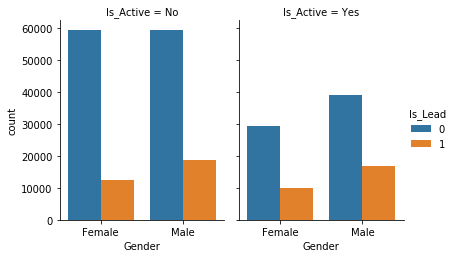

In [41]:
sns.catplot(x="Gender", col="Is_Active", hue="Is_Lead", col_wrap=2, data=raw_Data_treat, kind="count", height=3.5, aspect=.8)
plt.show()

Customer Activity seems to have some effect on balancing out the interest ratio for Credit Card business but there is a higher number of customer base which is inactive. The Happy Customer Bank need to take up engagement programs to ensure that such customer base does transact.

In [51]:
# Relation between Age and Is_Lead with respect to Gender

a = pd.DataFrame(raw_Data_treat.groupby(['Age','Is_Lead','Gender'])['Gender'].count())
a.columns = ['gender_count']
a.head()

gender_count
Age Is_Lead Gender              
23  0       Female             1
24  0       Female          1087
            Male             707
    1       Female            65
            Male              46

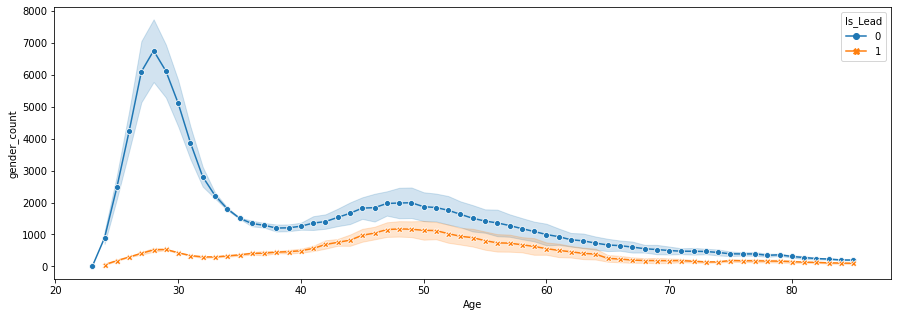

In [52]:
plt.figure(figsize=(15,5)) 
sns.lineplot(data=a, x="Age", y="gender_count", hue="Is_Lead", style="Is_Lead", markers=True, dashes=False)
plt.show()

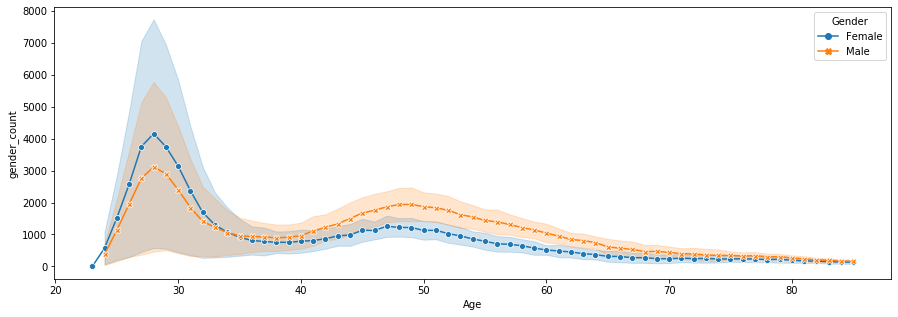

In [53]:
plt.figure(figsize=(15,5)) 
sns.lineplot(data=a, x="Age", y="gender_count", hue="Gender", style="Gender", markers=True, dashes=False)
plt.show()

Compared to Male, Happy Customer Bank has Female customer base starting at an early age with more number of females in the Young age group of 23-33 years of age who are interested for credit cards. The overall trend for interest in credit card seems decreasing with Age. There seems a small hike in number of Male customers at Middle age group of 35-60 years of age. The Happy Customer Bank seems popular among Young age group in terms of credit card business.

In [54]:
# Relation between Vintage and Is_Lead with respect to Gender

a = pd.DataFrame(raw_Data_treat.groupby(['Vintage','Is_Lead','Gender'])['Gender'].count())
a.columns = ['gender_count']
a.head()

gender_count
Vintage Is_Lead Gender              
7       0       Female           212
                Male             289
        1       Female            59
                Male              88
8       0       Female           215

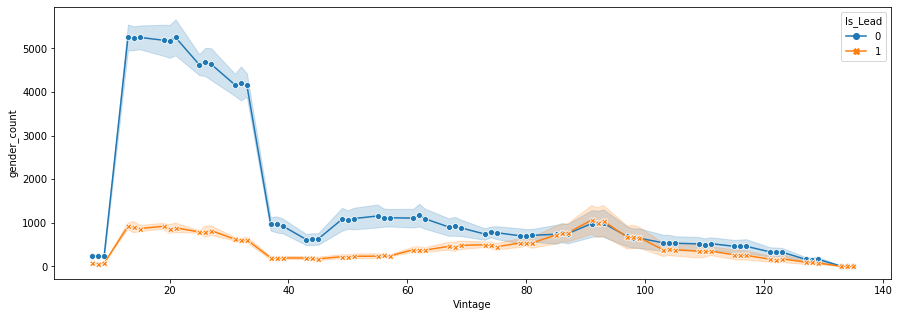

In [55]:
plt.figure(figsize=(15,5)) 
sns.lineplot(data=a, x="Vintage", y="gender_count", hue="Is_Lead", style="Is_Lead", markers=True, dashes=False)
plt.show()

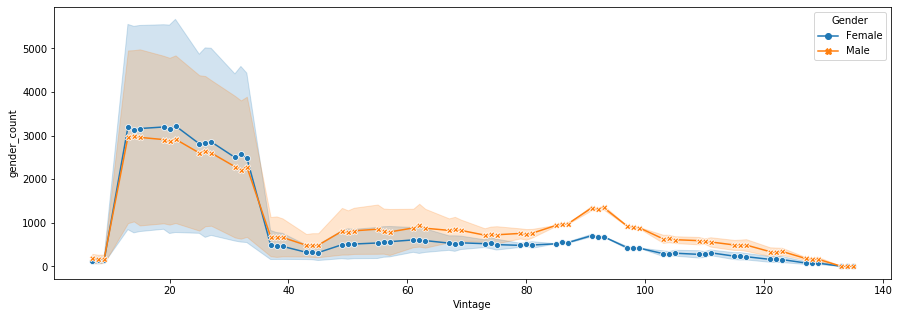

In [56]:
plt.figure(figsize=(15,5)) 
sns.lineplot(data=a, x="Vintage", y="gender_count", hue="Gender", style="Gender", markers=True, dashes=False)
plt.show()

Similar to Age feature lower the Vintage value greater is the interest shown in Credit Card. However, this may induce a risk. Financial Institutions rely on Vintage feature, for confidence in the business/individual as it  indicates the track-record of the business/individual and commitment of the business/individual.

A suggestion would be to have detailed KYC before offering credit card.

In [57]:
# Relation between Avg_Account_Balance and Is_Lead with respect to Gender

a = pd.DataFrame(raw_Data_treat.groupby(['Avg_Account_Balance','Is_Lead','Gender'])['Gender'].count())
a.columns = ['gender_count']
a.head()

gender_count
Avg_Account_Balance Is_Lead Gender              
20790               0       Male               1
45657               0       Female             1
45950               0       Female             1
                    1       Male               1
47526               0       Female             1

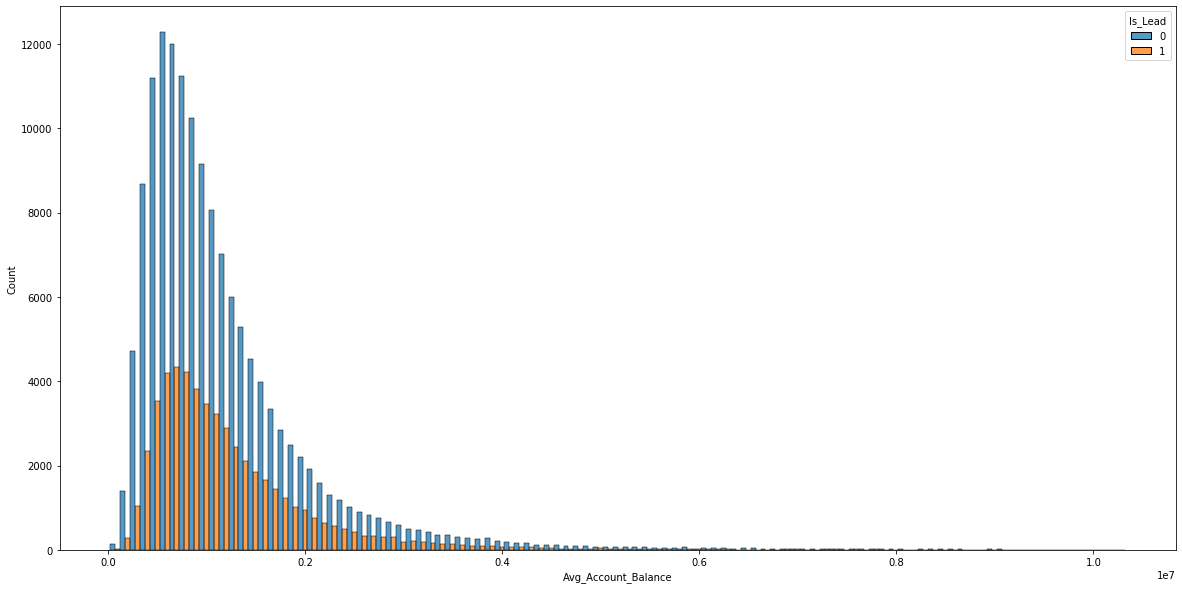

In [80]:
plt.figure(figsize=(20,10)) 
sns.histplot(data=a, x="Avg_Account_Balance", hue="Is_Lead", multiple="dodge", bins=range(20000,10352009,100000))
plt.show()

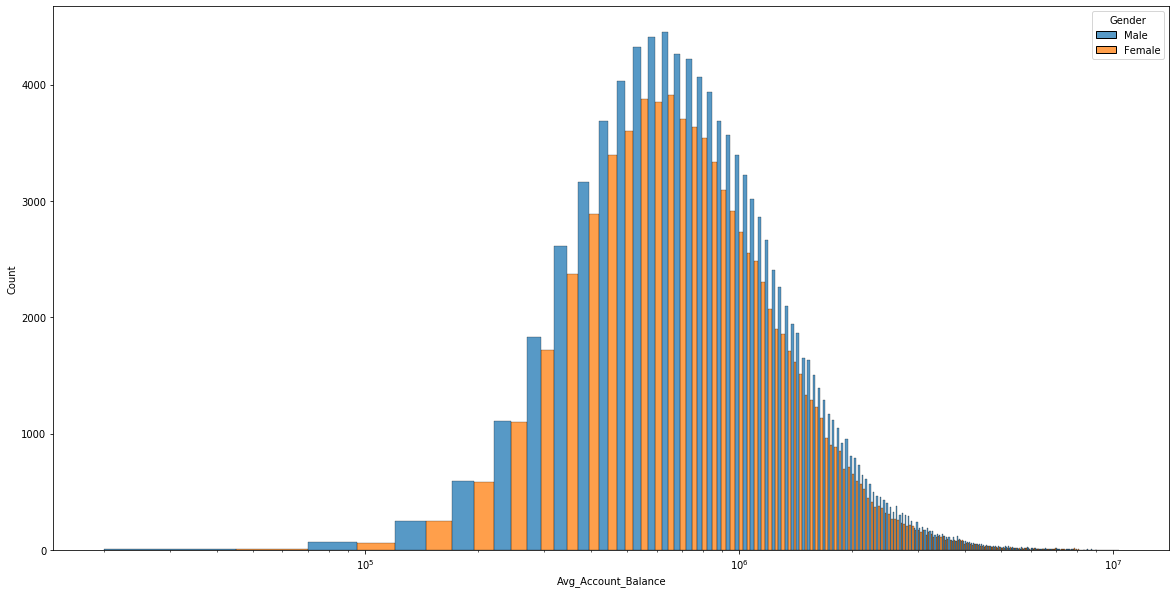

In [78]:
plt.figure(figsize=(20,10)) 
sns.histplot(data=a, x="Avg_Account_Balance", hue="Gender", multiple="dodge", bins=range(20000,10352009,50000))
plt.xscale('log')
plt.show()

From above data we could see most of the customers are maintaining a good average balance, however when it comes to showing interest in Credit Cards, the number seems low.

A suggestion would be to put efforts to tap the potential basis Avergae Account Balance as feature.

# Important Features

As per above exploratory data analysis the observed features seems to be

Age, Gender, Channel Code, Occupation, Credit_Product. These might not work in standalone but in combination.

# Model Building

In [101]:
raw_Data_train_Model_lb = raw_Data_treat.drop('ID', axis=1) 

In [102]:
# Converting categorical data to numeric using Label Encoding

def label_Encode(column):
    raw_Data_train_Model_lb[column] = raw_Data_train_Model_lb[column].astype('category').cat.codes

In [103]:
for column in ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']:
    label_Encode(column)

raw_Data_train_Model_lb.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active,Is_Lead
0,0,73,18,1,2,43,0,1045696,0,0
1,0,30,27,2,0,32,0,581988,0,0
2,0,56,18,3,2,26,0,1484315,1,0
3,1,34,20,2,0,19,0,470454,0,0
4,0,30,32,2,0,33,0,886787,0,0


In [110]:
X = raw_Data_train_Model_lb.drop('Is_Lead', axis=1)
y = raw_Data_train_Model_lb['Is_Lead']

train_x_lb, valid_x_lb, train_y_lb, valid_y_lb = train_test_split(X, y, test_size=0.3, random_state=7)

In [106]:
raw_Data_train_Model_OHE = raw_Data_treat.drop('ID', axis=1)

In [108]:
# Converting categorical data to numeric using One Hot Encoding

raw_Data_train_Model_OHE = pd.get_dummies(raw_Data_train_Model_OHE, columns=['Gender','Region_Code','Occupation',
                                                                             'Channel_Code','Credit_Product',
                                                                             'Is_Active'], 
                                          drop_first=False)

raw_Data_train_Model_OHE.head()

,Age,Vintage,Avg_Account_Balance,Is_Lead,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_Yes,Is_Active_No,Is_Active_Yes
0,73,43,1045696,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0
1,30,32,581988,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0
2,56,26,1484315,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1
3,34,19,470454,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0
4,30,33,886787,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0


In [111]:
X = raw_Data_train_Model_OHE.drop('Is_Lead', axis=1)
y = raw_Data_train_Model_OHE['Is_Lead']

train_x_OHE, valid_x_OHE, train_y_OHE, valid_y_OHE = train_test_split(X, y, test_size=0.3, random_state=7)

# Defining a Common Function to Train the model

In [109]:
def train_model(classifier, feature_train, label, feature_valid, valid_y):
    # fit the training dataset on the classifier
    classifier.fit(feature_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_valid)
    
    # calculating accuracy score
    acc_Score = accuracy_score(predictions, valid_y)
    class_Report = classification_report(valid_y, predictions)
    auc_roc_score = roc_auc_score(valid_y, predictions)
    
    return (acc_Score, class_Report, auc_roc_score)

# Naive Bayes Model of classification

In [113]:
# Naive Bayes on Label Encoder
acc_Score, class_Report, auc_roc_score = train_model(GaussianNB(), train_x_lb, train_y_lb, valid_x_lb, valid_y_lb)
print ("\n NB, Label Encoder Accuracy: \n", acc_Score)
print ("\n NB, Label Encoder Classification Report: \n", class_Report)
print ("\n NB, Label Encoder AUC_ROC Accuracy: \n", auc_roc_score)

# Naive Bayes on OHE
acc_Score, class_Report, auc_roc_score = train_model(GaussianNB(), train_x_OHE, train_y_OHE, valid_x_OHE, valid_y_OHE)
print ("\n NB, OHE Accuracy: \n", acc_Score)
print ("\n NB, OHE Classification Report: \n", class_Report)
print ("\n NB, OHE AUC_ROC Accuracy: \n", auc_roc_score)


 NB, Label Encoder Accuracy: 
 0.7561111261835644

 NB, Label Encoder Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.98      0.86     56238
           1       0.36      0.04      0.07     17480

    accuracy                           0.76     73718
   macro avg       0.56      0.51      0.46     73718
weighted avg       0.67      0.76      0.67     73718


 NB, Label Encoder AUC_ROC Accuracy: 
 0.5081208913685975

 NB, OHE Accuracy: 
 0.7562060826392468

 NB, OHE Classification Report: 
               precision    recall  f1-score   support

           0       0.77      0.98      0.86     56238
           1       0.36      0.04      0.06     17480

    accuracy                           0.76     73718
   macro avg       0.56      0.51      0.46     73718
weighted avg       0.67      0.76      0.67     73718


 NB, OHE AUC_ROC Accuracy: 
 0.5078480001998698


# Model Building with Linear Model for Classification

In [114]:
# Logistic Regression on Label Encoder
acc_Score, class_Report, auc_roc_score = train_model(LogisticRegression(solver='lbfgs'), train_x_lb, train_y_lb, 
                                                     valid_x_lb, valid_y_lb)
print ("\n LR, Label Encoder Accuracy: \n", acc_Score)
print ("\n LR, Label Encoder Classification Report: \n", class_Report)
print ("\n LR, Label Encoder AUC_ROC Accuracy: \n", auc_roc_score)

# Logistic Regression on OHE
acc_Score, class_Report, auc_roc_score = train_model(LogisticRegression(solver='lbfgs'), train_x_OHE, train_y_OHE, 
                                                     valid_x_OHE, valid_y_OHE)
print ("\n LR, OHE Accuracy: \n", acc_Score)
print ("\n LR, OHE Classification Report: \n", class_Report)
print ("\n LR, OHE AUC_ROC Accuracy: \n", auc_roc_score)

/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)



 LR, Label Encoder Accuracy: 
 0.7628801649529288

 LR, Label Encoder Classification Report: 
               precision    recall  f1-score   support

           0       0.76      1.00      0.87     56238
           1       0.00      0.00      0.00     17480

    accuracy                           0.76     73718
   macro avg       0.38      0.50      0.43     73718
weighted avg       0.58      0.76      0.66     73718


 LR, Label Encoder AUC_ROC Accuracy: 
 0.5

 LR, OHE Accuracy: 
 0.7628801649529288

 LR, OHE Classification Report: 
               precision    recall  f1-score   support

           0       0.76      1.00      0.87     56238
           1       0.00      0.00      0.00     17480

    accuracy                           0.76     73718
   macro avg       0.38      0.50      0.43     73718
weighted avg       0.58      0.76      0.66     73718


 LR, OHE AUC_ROC Accuracy: 
 0.5


/Users/pritigirishvankudre/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Model Building with Ensemble Model for Classification

In [115]:
# Random Forest on Label Encoder
acc_Score, class_Report, auc_roc_score = train_model(RandomForestClassifier(n_estimators=100), train_x_lb, 
                                                     train_y_lb, valid_x_lb, valid_y_lb)
print ("\n RF, Label Encoder Accuracy: \n", acc_Score)
print ("\n RF, Label Encoder Classification Report: \n", class_Report)
print ("\n RF, Label Encoder AUC_ROC Accuracy: \n", auc_roc_score)

# Random Forest on OHE
acc_Score, class_Report, auc_roc_score = train_model(RandomForestClassifier(n_estimators=100), train_x_OHE, 
                                                     train_y_OHE, valid_x_OHE, valid_y_OHE)
print ("\n RF, OHE Accuracy: \n", acc_Score)
print ("\n RF, OHE Classification Report: \n", class_Report)
print ("\n RF, OHE AUC_ROC Accuracy: \n", auc_roc_score)


 RF, Label Encoder Accuracy: 
 0.810304131962343

 RF, Label Encoder Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     56238
           1       0.62      0.52      0.56     17480

    accuracy                           0.81     73718
   macro avg       0.74      0.71      0.72     73718
weighted avg       0.80      0.81      0.80     73718


 RF, Label Encoder AUC_ROC Accuracy: 
 0.7092907203880077

 RF, OHE Accuracy: 
 0.8081472638975555

 RF, OHE Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     56238
           1       0.61      0.51      0.56     17480

    accuracy                           0.81     73718
   macro avg       0.74      0.71      0.72     73718
weighted avg       0.80      0.81      0.80     73718


 RF, OHE AUC_ROC Accuracy: 
 0.7064774388075914


# Defining a Common Function for GridSearchCV
(The configuration of parameters is invalid in some cases so to avoid exception/value error, we have introduced error_score parameter as 0.0, default value is 'raise')

In [116]:
def train_model_GridSearchCV(classifier, feature_train, label, feature_valid, valid_y, search_param):
    # define search
    search = GridSearchCV(classifier, search_param, scoring='roc_auc', cv=3, error_score=0.0)
    
    # execute search
    search.fit(feature_train, label)
    
    # predict the labels on validation dataset
    predictions = search.best_estimator_.predict(feature_valid)
    
    # calculating accuracy score
    auc_roc_score = search.best_score_
    best_Params = search.best_params_
    class_Report = classification_report(valid_y, predictions)
    
    return (auc_roc_score, best_Params, class_Report)

# GridSearchCV with Logistic Regression

In [117]:
import warnings
warnings.filterwarnings('ignore')

# Defining search parameters for Logistic Regression
search_param = dict()
search_param['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
search_param['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
search_param['C'] = [0.001, 0.01, 0.1, 1, 10, 100]

# Logistic Regression on Label Encoding
auc_roc_score, best_Params, class_Report = train_model_GridSearchCV(LogisticRegression(), train_x_lb, train_y_lb, 
                                                                    valid_x_lb, valid_y_lb, search_param)
print ("\n LR, Label Encoding ROC_AUC Accuracy: \n", auc_roc_score)
print ("\n LR, Label Encoding Best Hyperparameters: \n", best_Params)
print ("\n LR, Label Encoding Classification Report: \n", class_Report)

# Logistic Regression on OHE
auc_roc_score, best_Params, class_Report = train_model_GridSearchCV(LogisticRegression(), train_x_OHE, train_y_OHE, 
                                                                    valid_x_OHE, valid_y_OHE, search_param)
print ("\n LR, OHE ROC_AUC Accuracy: \n", auc_roc_score)
print ("\n LR, OHE Best Hyperparameters: \n", best_Params)
print ("\n LR, OHE Classification Report: \n", class_Report)


 LR, Label Encoding ROC_AUC Accuracy: 
 0.8256070269308537

 LR, Label Encoding Best Hyperparameters: 
 {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}

 LR, Label Encoding Classification Report: 
               precision    recall  f1-score   support

           0       0.84      0.91      0.88     56238
           1       0.62      0.45      0.52     17480

    accuracy                           0.80     73718
   macro avg       0.73      0.68      0.70     73718
weighted avg       0.79      0.80      0.79     73718


 LR, OHE ROC_AUC Accuracy: 
 0.8316056004440735

 LR, OHE Best Hyperparameters: 
 {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}

 LR, OHE Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.91      0.88     56238
           1       0.62      0.49      0.55     17480

    accuracy                           0.81     73718
   macro avg       0.74      0.70      0.71     73718
weighted avg       0.80      0

# GridSearchCV with Random Forest

In [118]:
import warnings
warnings.filterwarnings('ignore')

# Defining search parameters for Random Forest Classifier
search_param = dict()
search_param['n_estimators'] = [10, 100, 1000]
search_param['max_features'] = ['sqrt', 'log2']

# Random Forest Classifier on Label Encoding
auc_roc_score, best_Params, class_Report = train_model_GridSearchCV(RandomForestClassifier(), train_x_lb, 
                                                                    train_y_lb, valid_x_lb, valid_y_lb, 
                                                                    search_param)
print ("\n RF, Label Encoding ROC_AUC Accuracy: \n", auc_roc_score)
print ("\n RF, Label Encoding Best Hyperparameters: \n", best_Params)
print ("\n RF, Label Encoding Classification Report: \n", class_Report)

# Random Forest Classifier on OHE
auc_roc_score, best_Params, class_Report = train_model_GridSearchCV(RandomForestClassifier(), train_x_OHE, 
                                                                    train_y_OHE, valid_x_OHE, valid_y_OHE, 
                                                                    search_param)
print ("\n RF, OHE ROC_AUC Accuracy: \n", auc_roc_score)
print ("\n RF, OHE Best Hyperparameters: \n", best_Params)
print ("\n RF, OHE Classification Report: \n", class_Report)


 RF, Label Encoding ROC_AUC Accuracy: 
 0.8326178572183556

 RF, Label Encoding Best Hyperparameters: 
 {'max_features': 'sqrt', 'n_estimators': 1000}

 RF, Label Encoding Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     56238
           1       0.62      0.52      0.57     17480

    accuracy                           0.81     73718
   macro avg       0.74      0.71      0.72     73718
weighted avg       0.80      0.81      0.81     73718


 RF, OHE ROC_AUC Accuracy: 
 0.8284118652838894

 RF, OHE Best Hyperparameters: 
 {'max_features': 'sqrt', 'n_estimators': 1000}

 RF, OHE Classification Report: 
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     56238
           1       0.61      0.52      0.56     17480

    accuracy                           0.81     73718
   macro avg       0.74      0.71      0.72     73718
weighted avg       0.80      0.81     

# Predicting Is_Lead for Test Data

In [160]:
raw_Data_test = pd.read_csv('/Users/pritigirishvankudre/DayX_Lockdown Practice/CC_Lead_Pred/test.csv')
raw_Data_test.head()

,ID,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,VBENBARO,Male,29,RG254,Other,X1,25,Yes,742366,No
1,CCMEWNKY,Male,43,RG268,Other,X2,49,NaN,925537,No
2,VK3KGA9M,Male,31,RG270,Salaried,X1,14,No,215949,No
3,TT8RPZVC,Male,29,RG272,Other,X1,33,No,868070,No
4,SHQZEYTZ,Female,29,RG270,Other,X1,19,No,657087,No


In [161]:
raw_Data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105312 entries, 0 to 105311
Data columns (total 10 columns):
ID                     105312 non-null object
Gender                 105312 non-null object
Age                    105312 non-null int64
Region_Code            105312 non-null object
Occupation             105312 non-null object
Channel_Code           105312 non-null object
Vintage                105312 non-null int64
Credit_Product         92790 non-null object
Avg_Account_Balance    105312 non-null int64
Is_Active              105312 non-null object
dtypes: int64(3), object(7)
memory usage: 8.0+ MB


In [162]:
raw_Data_test['Credit_Product'].fillna('Yes', inplace=True)

In [163]:
raw_Data_test_lb = raw_Data_test.copy()
raw_Data_test_lb.drop('ID', axis=1, inplace=True)

In [164]:
# Converting categorical data to numeric using Label Encoding

def label_Encode(column):
    raw_Data_test_lb[column] = raw_Data_test_lb[column].astype('category').cat.codes

In [165]:
# Using Label Encoding

for column in ['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']:
    label_Encode(column)

raw_Data_test_lb.head()

,Gender,Age,Region_Code,Occupation,Channel_Code,Vintage,Credit_Product,Avg_Account_Balance,Is_Active
0,1,29,4,1,0,25,1,742366,0
1,1,43,18,1,1,49,1,925537,0
2,1,31,20,2,0,14,0,215949,0
3,1,29,22,1,0,33,0,868070,0
4,0,29,20,1,0,19,0,657087,0


In [166]:
raw_Data_test_OHE = raw_Data_test.copy()
raw_Data_test_OHE.drop('ID', axis=1, inplace=True)

In [167]:
# Converting categorical data to numeric using One Hot Encoding

raw_Data_test_OHE = pd.get_dummies(raw_Data_test_OHE, columns=['Gender','Region_Code','Occupation','Channel_Code',
                                                               'Credit_Product','Is_Active'], drop_first=False)

raw_Data_test_OHE.head()

,Age,Vintage,Avg_Account_Balance,Gender_Female,Gender_Male,Region_Code_RG250,Region_Code_RG251,Region_Code_RG252,Region_Code_RG253,Region_Code_RG254,Region_Code_RG255,Region_Code_RG256,Region_Code_RG257,Region_Code_RG258,Region_Code_RG259,Region_Code_RG260,Region_Code_RG261,Region_Code_RG262,Region_Code_RG263,Region_Code_RG264,Region_Code_RG265,Region_Code_RG266,Region_Code_RG267,Region_Code_RG268,Region_Code_RG269,Region_Code_RG270,Region_Code_RG271,Region_Code_RG272,Region_Code_RG273,Region_Code_RG274,Region_Code_RG275,Region_Code_RG276,Region_Code_RG277,Region_Code_RG278,Region_Code_RG279,Region_Code_RG280,Region_Code_RG281,Region_Code_RG282,Region_Code_RG283,Region_Code_RG284,Occupation_Entrepreneur,Occupation_Other,Occupation_Salaried,Occupation_Self_Employed,Channel_Code_X1,Channel_Code_X2,Channel_Code_X3,Channel_Code_X4,Credit_Product_No,Credit_Product_Yes,Is_Active_No,Is_Active_Yes
0,29,25,742366,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0
1,43,49,925537,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0
2,31,14,215949,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0
3,29,33,868070,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0
4,29,19,657087,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0


# Definfing a common function to test the model

In [168]:
def test_model(feature_valid, classifier, feature_train, label):
    # fit the training dataset on the classifier
    classifier.fit(feature_train, label)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(feature_valid)
    
    return (predictions)

# Logistic Regression with best parameters

In [169]:
prediction_LR_lb = test_model(raw_Data_test_lb, 
                              LogisticRegression(C=10, penalty='l1', solver= 'liblinear'), 
                              train_x_lb, train_y_lb)
raw_Data_test['Is_Lead'] = pd.DataFrame(prediction_LR_lb)
raw_Data_test.to_csv('LR_LB_CV_Test_3005_00_2200.csv', columns=['ID','Is_Lead'], header=True, index=False)
raw_Data_test.drop('Is_Lead', axis=1, inplace=True)

prediction_LR_OHE = test_model(raw_Data_test_OHE, 
                               LogisticRegression(C=0.01, penalty='l2', solver='newton-cg'), 
                               train_x_OHE, train_y_OHE)
raw_Data_test['Is_Lead'] = pd.DataFrame(prediction_LR_OHE)
raw_Data_test.to_csv('LR_OHE_CV_Test_3005_01_2200.csv', columns=['ID','Is_Lead'], header=True, index=False)
raw_Data_test.drop('Is_Lead', axis=1, inplace=True)

# Random Forest with best parameters

In [170]:
prediction_RF_lb = test_model(raw_Data_test_lb, 
                              RandomForestClassifier(max_features='sqrt', n_estimators=1000), 
                              train_x_lb, train_y_lb)
raw_Data_test['Is_Lead'] = pd.DataFrame(prediction_RF_lb)
raw_Data_test.to_csv('RF_LB_CV_Test_3005_00_2200.csv', columns=['ID','Is_Lead'], header=True, index=False)
raw_Data_test.drop('Is_Lead', axis=1, inplace=True)

prediction_RF_OHE = test_model(raw_Data_test_OHE, 
                              RandomForestClassifier(max_features='sqrt', n_estimators=1000), 
                              train_x_OHE, train_y_OHE)
raw_Data_test['Is_Lead'] = pd.DataFrame(prediction_RF_OHE)
raw_Data_test.to_csv('RF_OHE_CV_Test_3005_01_2200.csv', columns=['ID','Is_Lead'], header=True, index=False)
raw_Data_test.drop('Is_Lead', axis=1, inplace=True)